## Project Workflow

### 1. Dataset Preparation
   - Organize and preprocess training, validation, and test datasets using `dataset.py`.
   - Ensure data is properly structured to support model training and evaluation.

### 2. Data Augmentation
   - Enhance model generalization by applying geometric and visual transformations using `dataset.py` and `organisation.py`.
   - Consolidate augmented data into a finalized dataset folder to serve as input for the model.

### 3. Model Training
   Results of the train model versions, YOLOX (large version) and YOLON (nano version).

### 4. Visualization and Evaluation
   - Visualize predictions on validation and test datasets using `model.py`.
   - Conduct a thorough performance evaluation, with all metrics stored in the corresponding model directories (model/YOLOX and model/YOLON).

In [1]:
from tifffile import tifffile 
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
from PIL import Image
from model import *

from ultralytics import YOLO
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torch
import torchvision.transforms as T
import os
import shutil
import cv2
import dataset as dt
import organisation as  org

## 1. Dataset Preparation

In [2]:
# Combine RGB and hillshade images - the red band is replaced by hillshade

# Define the paths for the folders
rgb_folder_origin = 'LargeRocksDetectionDataset/swissImage_50cm_patches/'
hillshade_folder_origin = 'LargeRocksDetectionDataset/swissSURFACE3D_hillshade_patches/'

rgb_folder = 'rgb_images/'
os.makedirs(rgb_folder, exist_ok=True)
shutil.copytree(rgb_folder_origin, rgb_folder, dirs_exist_ok=True)

hillshade_folder = 'hillshade_images/'
os.makedirs(hillshade_folder, exist_ok=True)
shutil.copytree(hillshade_folder_origin, hillshade_folder, dirs_exist_ok=True)

dt.convert_tif_to_jpg(rgb_folder)
dt.convert_tif_to_jpg(hillshade_folder)

combined_img_folder = 'combined_images/'
os.makedirs(combined_img_folder, exist_ok=True)

# Get the list of image names in the RGB folder
image_names = os.listdir(rgb_folder)

for image_name in image_names:
    # Construct full file paths
    rgb_path = os.path.join(rgb_folder, image_name)
    hillshade_path = os.path.join(hillshade_folder, image_name)
    output_path = os.path.join(combined_img_folder, image_name)

    # Load the RGB and hillshade images
    rgb_image = cv2.imread(rgb_path)
    hillshade_image = cv2.imread(hillshade_path, cv2.IMREAD_GRAYSCALE)

    # Check if both images are loaded correctly
    if rgb_image is None or hillshade_image is None:
        print(f"Error loading images for {image_name}. Skipping.")
        continue

    # Replace the red channel in the RGB image with the hillshade image
    rgb_image[:, :, 2] = hillshade_image  # OpenCV uses BGR format, so red channel is index 2

    # Save the modified image to the output folder
    cv2.imwrite(output_path, rgb_image)

print("Images have been combined and saved.")

shutil.rmtree(rgb_folder)
shutil.rmtree(hillshade_folder)

All .tif files have been converted to .jpg and replaced.
All .tif files have been converted to .jpg and replaced.
Images have been combined and saved.


In [3]:
# Load dataset from JSON
json_file_path = 'LargeRocksDetectionDataset/large_rock_dataset.json' 
data, dataset = dt.load_dataset_from_json(json_file_path)

# Define base directory name where the images and labels will be stored
base_dir_name = f'dataset_combined_images'

# Split and organize the dataset
train_images, test = dt.split_train_from_json(dataset, combined_img_folder, base_dir_name)
train_labels = dt.save_train_annotations(dataset, base_dir_name)

# Create a validation set
val_images = dt.create_validation_set_images(train_images, base_dir_name)
val_labels = dt.create_validation_set_labels(train_labels, base_dir_name)

# Write the labels in Yolov8 format
# YOLOv8 assumes constant bbox size 
bbox_width = 30 / 640  # Normalized width
bbox_height = 30 / 640  # Normalized height

dt.convert_labels_to_yolo_format(
    train_labels,
    base_dir_name,
    bbox_width=bbox_width,
    bbox_height=bbox_height,
    type='train'
)

dt.convert_labels_to_yolo_format(
    val_labels,
    base_dir_name,
    bbox_width=bbox_width,
    bbox_height=bbox_height,
    type='val'
)

Dataset split completed.
All train annotations have been saved to the 'train_labels' folder.
Moved 64 files to 'dataset_combined_images/val_images'.
Matching label files moved to 'val_labels' folder.
Conversion to YOLOv8 format completed.
Conversion to YOLOv8 format completed.


## 2. Data Augmentation

In [4]:
# Initialize and inspect the dataset

# Set paths for training images and YOLO-format labels.
image_folder = "dataset_combined_images/train_images"
label_folder = "dataset_combined_images/yolo_train_labels"

# Calculate mean and standard deviation for normalization.
mean, std = dt.calculate_mean_std(image_folder)

# Create the RockDetectionDataset with normalization (no augmentation for now).
dataset = dt.RockDetectionDataset(image_folder, label_folder, mean, std, augment=False)

# Iterate through the dataset to:
#  - Print the image name, tensor shape, and associated labels.
#  - Break after the first iteration for quick inspection.
for idx, (aug_images, aug_labels) in enumerate(dataset):
    image_name = dataset.image_files[idx]  # Get the name of the current image
    print(f"Image Name: {image_name}")
    print(f"Image Shape: {aug_images.size()}")
    print(f"Labels: {aug_labels}")
    break

Image Name: 2581_1126_0_0.jpg
Image Shape: torch.Size([3, 640, 640])
Labels: tensor([[0.0000, 0.4400, 0.2700, 0.0469, 0.0469],
        [0.0000, 0.5100, 0.3900, 0.0469, 0.0469],
        [0.0000, 0.5700, 0.4500, 0.0469, 0.0469],
        [0.0000, 0.5700, 0.3800, 0.0469, 0.0469],
        [0.0000, 0.3700, 0.7600, 0.0469, 0.0469],
        [0.0000, 0.3000, 0.7100, 0.0469, 0.0469],
        [0.0000, 0.3900, 0.9200, 0.0469, 0.0469]])


In [5]:
# Data Augmentation Workflow: Geometric, Brightness, and Obstruction
# This script performs three types of augmentations (Geometric, Brightness, and Obstruction)
# and saves the augmented datasets into separate folders.

dataset_combined_images = 'dataset_combined_images/'

# Parameters
batch_size = 16 

# Geometric
output_image_folder_g = os.path.join(dataset_combined_images, "augmented_train_images_geom")
output_label_folder_g = os.path.join(dataset_combined_images, "augmented_train_labels_geom")

org.aug_pipeline_geom(dataset, mean, std, batch_size, output_image_folder_g, output_label_folder_g)

Geometric augmentation completed.


In [6]:
# Brightness
output_image_folder_b = os.path.join(dataset_combined_images, "augmented_train_images_brightning")
output_label_folder_b = os.path.join(dataset_combined_images, "augmented_train_labels_brightning")

org.aug_pipeline_brightning(dataset, mean, std, batch_size, output_image_folder_b, output_label_folder_b)

Brightning augmentation completed.


In [7]:
# Obstruction
output_image_folder_o = os.path.join(dataset_combined_images, "augmented_train_images_obstruction")
output_label_folder_o = os.path.join(dataset_combined_images, "augmented_train_labels_obstruction")

org.aug_pipeline_obstruction(dataset, mean, std, batch_size, output_image_folder_o, output_label_folder_o)

Obstruction augmentation completed.


### Organisation of input dataset for the model

In [8]:
org.organize_yolo_dataset(dataset_combined_images)

shutil.rmtree(combined_img_folder)
shutil.rmtree(dataset_combined_images)

YOLO dataset organized in 'yolo_dataset'


## 3. Model Trainning

In this section, we present the code used to train the two different models (large and nano), note these model were trained using the GPU from google colab. Each epoch takes approximatively 30s with the A100 GPU, therefore the large model took 2h to compile over 200 epochs. 

In [2]:
# Define the model inputs and the paths to the model and the predictions for the validation and test sets
model_inputs = {
    'large': ('yolov8x.yaml','model/Yolox', 'model/predictions_large', 'model/predictions_large_test'),
    'nano': ('yolov8n.yaml','model/Yolon', 'model/predictions_nano', 'model/predictions_nano_test')
}
yaml_file_path = 'yolo_dataset/yolo_description.yaml'
validation_set_path = 'yolo_dataset/val_dataset'
validation_set_image_path = 'yolo_dataset/val_dataset/images'
validation_set_label_path = 'yolo_dataset/val_dataset/labels'
test_set_path = 'yolo_dataset/test_dataset/images'

The following commented code was used to train the model.

In [ ]:
# Train both versions of Yolov8

# for model_name, (model,save_dir, _) in model_inputs.items():
#     trained_model = train_model(model_name, model, yaml_file_path, save_dir)

At the end of the training, the model produced these values :
| Model | Epoch | train/box_loss | train/cls_loss | train/dfl_loss | metrics/precision(B) | metrics/recall(B) | metrics/mAP50(B) | metrics/mAP50-95(B) |
|-------|-------|----------------|----------------|----------------|-----------------------|-------------------|------------------|---------------------|
| Nano  | 200   | 1.5545         | 1.73322        | 1.02968        | 0.67396               | 0.49345           | 0.56672          | 0.29903             |
| Large | 200   | 1.13502        | 0.92061        | 0.93936        | 0.83076               | 0.65502           | 0.75898          | 0.43399             |


## 4. Visualisation of the results 

On the validation set (with the groundtruth alongside it):

In [ ]:
# Prediction of each model on the validation set
for model_name, (_, save_dir, save_dir_pred, _) in model_inputs.items():
    predictions = predict_model(save_dir, validation_set_image_path, save_dir_pred)
    print(f'Predictions for {model_name} finished')

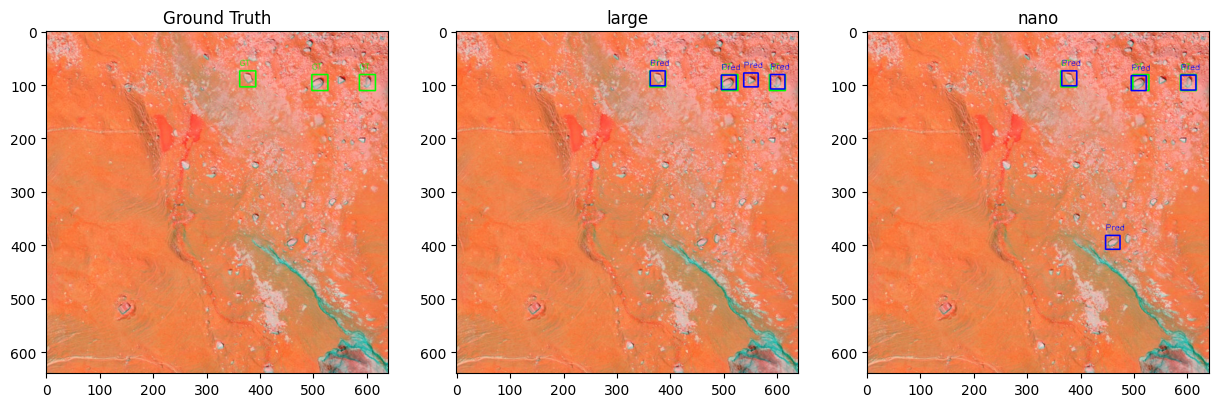

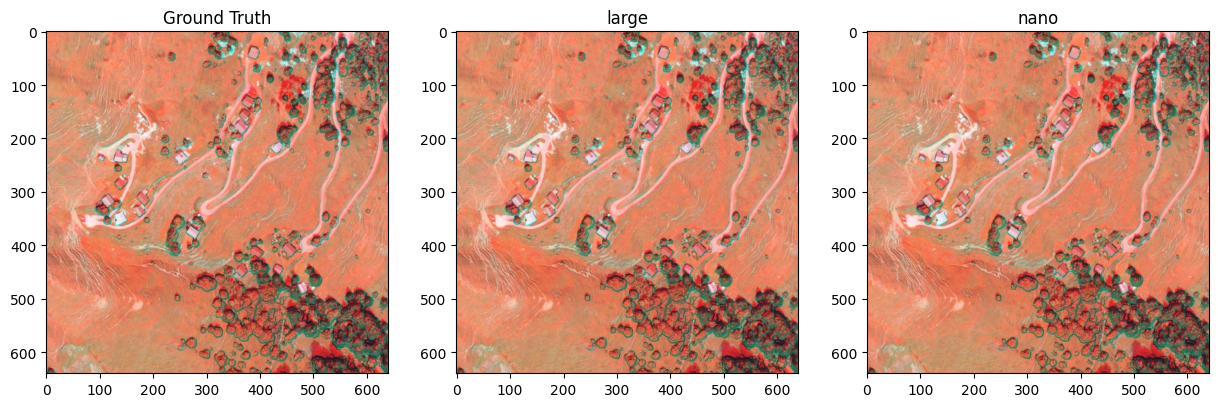

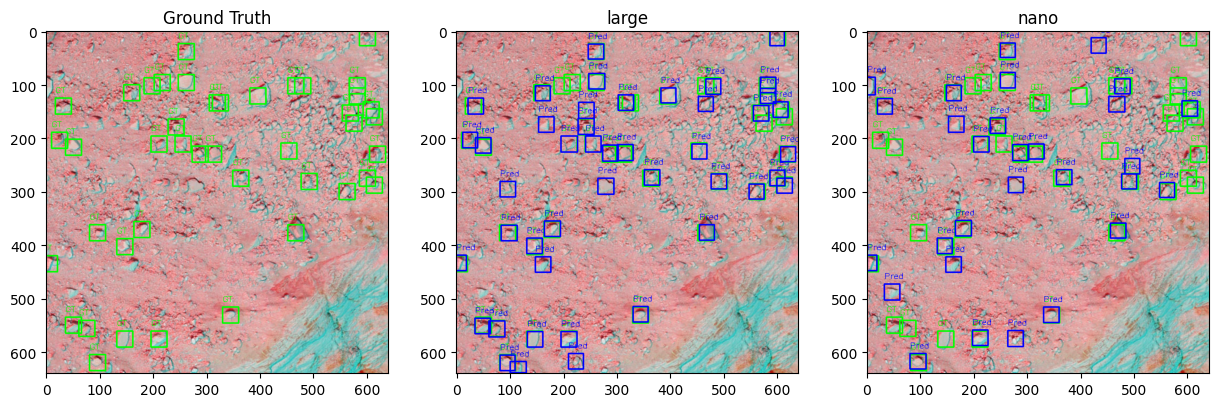

In [16]:
plot_model_predictions(validation_set_image_path, validation_set_label_path, model_inputs)

On the test set:

In [ ]:
# Predict using models on test set for RGB and hillshade
for model_name, (_, save_dir, _, save_dir_pred) in model_inputs.items():
    predictions_test = predict_model(save_dir, test_set_path, save_dir_pred)
    # predictions_hillshade = predict_model(save_dir, test_set_path_hillshade, save_dir_pred + '_hillshade')
    print(f'Predictions for {model_name} on RGB and hillshade finished')

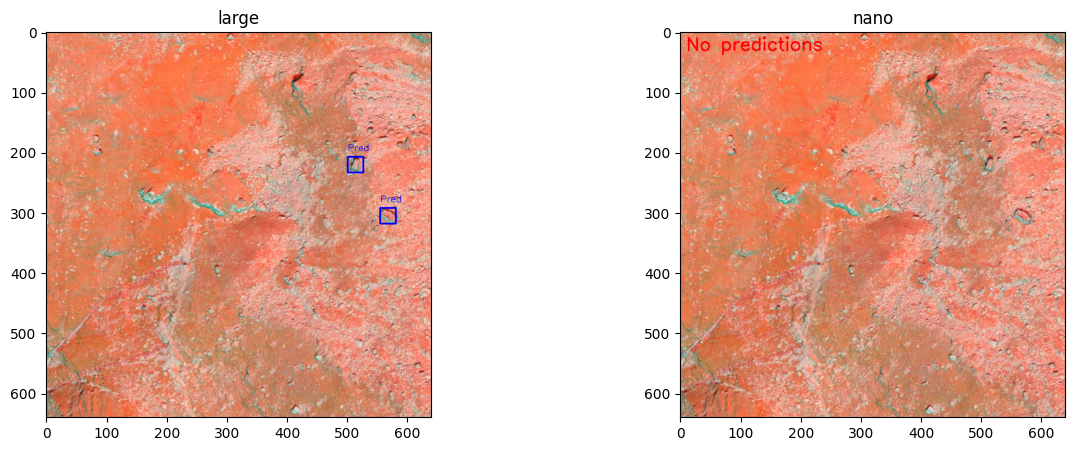

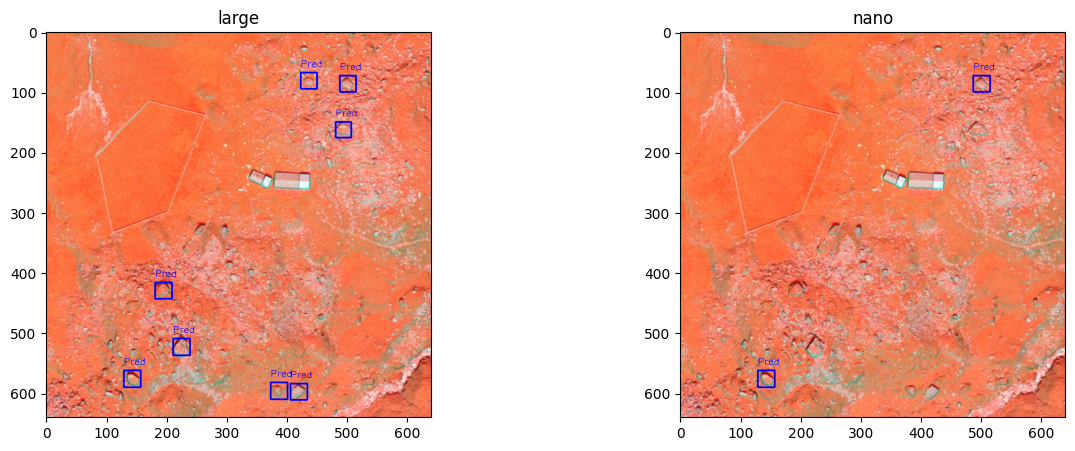

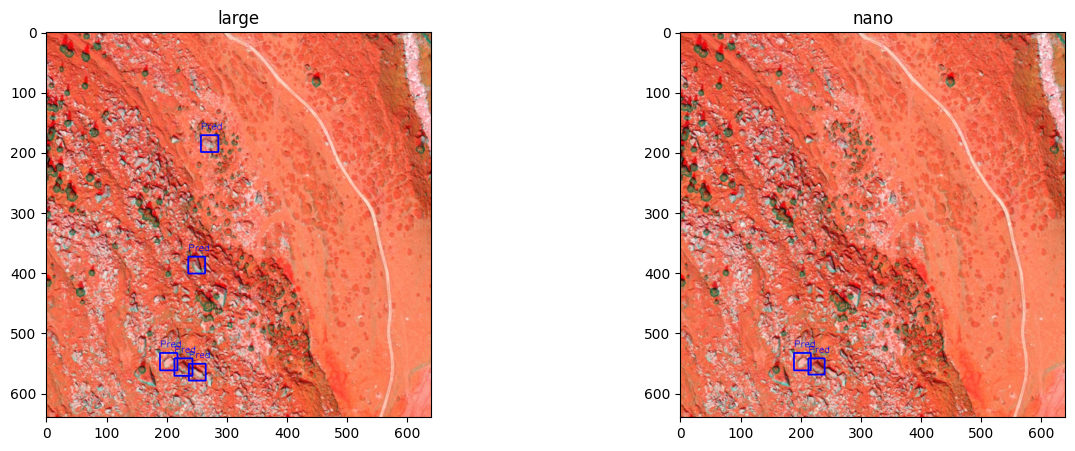

In [9]:
plot_test_predictions(test_set_path, model_inputs)